In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import re
import xgboost

from pandas.api.types import CategoricalDtype

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from statsmodels.graphics.tsaplots import plot_pacf
from xgboost import XGBRegressor
import lightgbm

In [2]:
all_csv = pd.read_csv('cleaned.csv.gz',
                 dtype = {
                     'store_nbr' : 'category',
                     'family' : 'category',
                     'sales': 'float',
                     'city': 'category',
                     'state': 'category',
                     'type': 'category',
                     'holiday_type': 'category',
                     'holiday_transferred': 'category'
                 },
                  parse_dates=['date'])
all_csv['date'] = pd.to_datetime(all_csv['date']).dt.to_period('D')

In [3]:
all = all_csv.copy()  # we can start experimenting from here without reloading the csv file

In [4]:
# this is for experimentation

filter_by_stores = None  # note: please use string here (unlike Mine.ipynb)
filter_by_family = None
filter_by_dates = None

#filter_by_stores = ['15']  # note: please use string here (unlike Mine.ipynb)
#filter_by_family = ['PRODUCE', 'AUTOMOBILE']
#filter_by_dates = '2014-06-05'

In [5]:
if filter_by_dates == None:
    train_start_date = '2013-01-01'
else:
    train_start_date = filter_by_dates
train_end_date = '2017-08-15'
test_start_date = '2017-08-16'
test_end_date = '2017-08-31'

In [6]:
if filter_by_family != None:
    all = all[all['family'].isin(filter_by_family)]
if filter_by_stores != None:
    all = all[all['store_nbr'].isin(filter_by_stores)]
if filter_by_dates != None:
    all = all[all['date'] >= filter_by_dates]

In [7]:
all['store_nbr'].unique()

['1', '10', '11', '12', '13', ..., '54', '6', '7', '8', '9']
Length: 54
Categories (54, object): ['1', '10', '11', '12', ..., '6', '7', '8', '9']

In [8]:
all.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3036528 entries, 0 to 3036527
Data columns (total 38 columns):
 #   Column               Dtype    
---  ------               -----    
 0   date                 period[D]
 1   store_nbr            category 
 2   family               category 
 3   sales                float64  
 4   onpromotion          int64    
 5   sales_lag_01         float64  
 6   sales_lag_02         float64  
 7   sales_lag_03         float64  
 8   sales_lag_04         float64  
 9   sales_lag_05         float64  
 10  sales_lag_06         float64  
 11  sales_lag_07         float64  
 12  sales_lag_08         float64  
 13  sales_lag_09         float64  
 14  sales_lag_10         float64  
 15  sales_lag_11         float64  
 16  sales_lag_12         float64  
 17  sales_lag_13         float64  
 18  sales_lag_14         float64  
 19  sales_lag_15         float64  
 20  sales_lag_16         float64  
 21  sales_lag_17         float64  
 22  sales_lag_18      

In [9]:


dtypes = all.dtypes.to_dict()

for col_name, typ in dtypes.items():
    if typ == 'float64':
        all =all.astype({col_name: 'float32'})
    if typ == 'int64':
        all =all.astype({col_name: 'int32'})

all['store_nbr']=all.store_nbr.astype('int8')

all['onpromotion']=all.onpromotion.astype('int16')
# all = all.drop(['sales_lag_01', 'sales_lag_02', 'sales_lag_03', 'sales_lag_04', 'sales_lag_05', 'sales_lag_06', 'sales_lag_07', 'sales_lag_08', 'sales_lag_09', 'sales_lag_10'], axis=1)
# all = all.drop(['sales_lag_11', 'sales_lag_12', 'sales_lag_13', 'sales_lag_14', 'sales_lag_15', 'sales_lag_16', 'sales_lag_17', 'sales_lag_18', 'sales_lag_19', 'sales_lag_20'], axis=1)

In [18]:
all.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3036528 entries, 0 to 3036527
Data columns (total 38 columns):
 #   Column               Dtype    
---  ------               -----    
 0   date                 period[D]
 1   store_nbr            int8     
 2   family               int64    
 3   sales                float32  
 4   onpromotion          int16    
 5   sales_lag_01         float32  
 6   sales_lag_02         float32  
 7   sales_lag_03         float32  
 8   sales_lag_04         float32  
 9   sales_lag_05         float32  
 10  sales_lag_06         float32  
 11  sales_lag_07         float32  
 12  sales_lag_08         float32  
 13  sales_lag_09         float32  
 14  sales_lag_10         float32  
 15  sales_lag_11         float32  
 16  sales_lag_12         float32  
 17  sales_lag_13         float32  
 18  sales_lag_14         float32  
 19  sales_lag_15         float32  
 20  sales_lag_16         float32  
 21  sales_lag_17         float32  
 22  sales_lag_18      

In [11]:
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
ordinal_encoder = OrdinalEncoder(dtype=int)
all[['family']] = ordinal_encoder.fit_transform(all[['family']])
 

In [12]:

X = all[all['date'] <= train_end_date]
# X = X.drop(['sales'], axis=1)
# y = all[['date', 'sales']][all['date'] <= train_end_date]
# y.set_index('date', inplace=True)

X_test = all[all['date'] >= test_start_date]
# X_test = X_test.drop(['sales'], axis=1)

# X.drop('date', axis=1, inplace=True)
# X_test.drop('date', axis=1, inplace=True)
# y.set_index(X.index, inplace=True)
# train_all, val_all = train_test_split(X, random_state=1,shuffle=False, test_size=0.05)

In [13]:
def pivot_data(input_data, idx, cols, value):
    return input_data.pivot(index=idx, columns=cols, values=value)

In [14]:
X_pivoted = pivot_data(X, ['date'], ['store_nbr', 'family'], 'sales')

In [172]:
X_test_pivoted = pivot_data(X_test, ['date'], ['store_nbr', 'family'], 'sales')

In [19]:
X_pivoted

store_nbr          1                                                         \
family            0    1         2         3         4         5         6    
date                                                                          
2013-01-01  1.098612  0.0  0.693147  6.734591  0.693147  5.188285  2.833213   
2013-01-02  1.098612  0.0  1.098612  6.995766  0.693147  6.156241  2.833213   
2013-01-03  1.386294  0.0  1.945910  6.824374  0.000000  5.741897  2.564949   
2013-01-04  1.386294  0.0  1.386294  6.860664  0.000000  5.295142  3.091043   
2013-01-05  1.791759  0.0  1.386294  7.057037  0.693147  5.710616  2.890372   
...              ...  ...       ...       ...       ...       ...       ...   
2017-08-11  0.693147  0.0  0.693147  6.914731  0.000000  4.987756  1.609438   
2017-08-12  1.945910  0.0  1.386294  7.414573  0.000000  5.498069  1.386294   
2017-08-13  0.693147  0.0  0.693147  6.689599  0.000000  4.924925  0.693147   
2017-08-14  0.693147  0.0  1.945910  7.697121  0.000000  5.849434  1.609438   
2017-08-15  1.609438  0.0  1.609438  7.571989  0.000000  5.800731  3.091043   

store_nbr                                 ...         9                      \
family            7         8         9   ...        23        24        25   
date                                      ...                                 
2013-01-01  6.059123  6.084499  4.352134  ...  1.791759  5.861031  5.843544   
2013-01-02  6.966967  6.363028  5.106364  ...  2.564949  5.928341  6.180017   
2013-01-03  6.729824  6.118097  5.027702  ...  2.484907  5.996111  5.921578   
2013-01-04  6.719013  6.133398  4.885911  ...  1.945910  5.742612  5.783825   
2013-01-05  6.699501  6.142037  4.784262  ...  2.890372  6.106321  6.135565   
...              ...       ...       ...  ...       ...       ...       ...   
2017-08-11  5.834811  5.840641  4.179023  ...  1.791759  5.737362  5.924256   
2017-08-12  5.863631  6.267200  4.610038  ...  1.098612  5.565661  5.993961   
2017-08-13  5.135798  5.587249  3.887115  ...  1.386294  5.793642  6.236370   
2017-08-14  6.349139  6.551080  5.047147  ...  2.564949  5.805059  6.100319   
2017-08-15  6.556778  6.401917  4.765604  ...  2.484907  6.109754  6.259582   

store_nbr                                                               \
family            26        27        28        29        30        31   
date                                                                     
2013-01-01  2.302585  2.772589  6.579994  4.644968  7.603877  1.386294   
2013-01-02  1.609438  2.564949  6.480492  4.430817  7.643729  1.098612   
2013-01-03  2.484907  2.397895  6.235383  4.204693  7.428047  1.609438   
2013-01-04  1.791759  3.135494  5.810158  4.060443  7.016474  0.693147   
2013-01-05  1.945910  3.044523  6.238166  4.442651  7.586124  1.791759   
...              ...       ...       ...       ...       ...       ...   
2017-08-11  2.484907  1.098612  6.265727  4.728272  7.282127  4.948760   
2017-08-12  2.079442  2.397895  5.951650  4.874464  7.258598  4.934474   
2017-08-13  1.098612  2.302585  6.024556  4.665032  7.435206  5.303305   
2017-08-14  1.098612  2.708050  5.650484  4.745975  7.207434  5.209486   
2017-08-15  1.945910  1.945910  6.084802  5.046987  7.791824  4.804021   

store_nbr             
family            32  
date                  
2013-01-01  2.972054  
2013-01-02  3.408305  
2013-01-03  3.258096  
2013-01-04  2.484907  
2013-01-05  3.379667  
...              ...  
2017-08-11  3.212093  
2017-08-12  2.882508  
2017-08-13  3.044523  
2017-08-14  2.890372  
2017-08-15  2.833213  

[1688 rows x 1782 columns]

In [20]:
total_rows = len(X_pivoted)

In [21]:
train_split = int (total_rows* 0.9)

In [22]:
train_all ,val_all = X_pivoted[:train_split], X_pivoted[train_split:]

In [41]:
#pivot_data(val_all, ['date'], ['store_nbr', 'family'], 'sales')

In [23]:
#train_all =  pivot_data(train_all, ['date'], ['store_nbr', 'family'], 'sales')
#val_all = pivot_data(val_all, ['date'], ['store_nbr', 'family'], 'sales')
train_all


store_nbr          1                                                         \
family            0    1         2         3         4         5         6    
date                                                                          
2013-01-01  1.098612  0.0  0.693147  6.734591  0.693147  5.188285  2.833213   
2013-01-02  1.098612  0.0  1.098612  6.995766  0.693147  6.156241  2.833213   
2013-01-03  1.386294  0.0  1.945910  6.824374  0.000000  5.741897  2.564949   
2013-01-04  1.386294  0.0  1.386294  6.860664  0.000000  5.295142  3.091043   
2013-01-05  1.791759  0.0  1.386294  7.057037  0.693147  5.710616  2.890372   
...              ...  ...       ...       ...       ...       ...       ...   
2017-02-23  0.693147  0.0  1.791759  7.562161  0.000000  6.080885  3.135494   
2017-02-24  2.639057  0.0  1.609438  7.827640  0.000000  5.962260  2.302585   
2017-02-25  1.098612  0.0  1.098612  7.695758  0.000000  5.871577  2.079442   
2017-02-26  0.693147  0.0  0.693147  6.538140  0.000000  4.828914  1.609438   
2017-02-27  1.386294  0.0  1.609438  6.507277  0.000000  4.662382  3.135494   

store_nbr                                 ...         9                      \
family            7         8         9   ...        23        24        25   
date                                      ...                                 
2013-01-01  6.059123  6.084499  4.352134  ...  1.791759  5.861031  5.843544   
2013-01-02  6.966967  6.363028  5.106364  ...  2.564949  5.928341  6.180017   
2013-01-03  6.729824  6.118097  5.027702  ...  2.484907  5.996111  5.921578   
2013-01-04  6.719013  6.133398  4.885911  ...  1.945910  5.742612  5.783825   
2013-01-05  6.699501  6.142037  4.784262  ...  2.890372  6.106321  6.135565   
...              ...       ...       ...  ...       ...       ...       ...   
2017-02-23  6.496775  6.605298  4.448107  ...  0.693147  6.162841  5.799093   
2017-02-24  6.526495  6.674562  5.265345  ...  1.386294  5.591338  5.817111   
2017-02-25  6.480044  6.559615  5.058282  ...  1.386294  6.013371  6.655440   
2017-02-26  5.398163  5.429346  3.820807  ...  1.098612  5.906138  6.298949   
2017-02-27  4.983607  5.214936  3.861319  ...  2.484907  5.987923  6.230482   

store_nbr                                                               \
family            26        27        28        29        30        31   
date                                                                     
2013-01-01  2.302585  2.772589  6.579994  4.644968  7.603877  1.386294   
2013-01-02  1.609438  2.564949  6.480492  4.430817  7.643729  1.098612   
2013-01-03  2.484907  2.397895  6.235383  4.204693  7.428047  1.609438   
2013-01-04  1.791759  3.135494  5.810158  4.060443  7.016474  0.693147   
2013-01-05  1.945910  3.044523  6.238166  4.442651  7.586124  1.791759   
...              ...       ...       ...       ...       ...       ...   
2017-02-23  1.386294  2.302585  5.938936  4.884845  7.042297  0.693147   
2017-02-24  1.945910  1.791759  6.003536  4.569864  6.961898  1.791759   
2017-02-25  2.197225  3.295837  6.222509  5.102813  7.506379  1.098612   
2017-02-26  2.564949  3.091043  6.219299  4.836639  7.350065  0.693147   
2017-02-27  2.197225  2.564949  6.136406  4.801033  7.265448  1.098612   

store_nbr             
family            32  
date                  
2013-01-01  2.972054  
2013-01-02  3.408305  
2013-01-03  3.258096  
2013-01-04  2.484907  
2013-01-05  3.379667  
...              ...  
2017-02-23  2.397895  
2017-02-24  2.302585  
2017-02-25  2.397895  
2017-02-26  2.772589  
2017-02-27  2.995732  

[1519 rows x 1782 columns]

In [24]:
val_all

store_nbr          1                                                         \
family            0    1         2         3         4         5         6    
date                                                                          
2017-02-28  1.098612  0.0  1.098612  6.966024  0.000000  4.907066  2.079442   
2017-03-01  0.693147  0.0  1.386294  8.114923  0.000000  6.337979  2.708050   
2017-03-02  1.386294  0.0  2.197225  7.832014  0.000000  6.019537  3.135494   
2017-03-03  1.791759  0.0  2.302585  7.838737  0.000000  6.152807  3.135494   
2017-03-04  1.945910  0.0  1.791759  7.854769  0.693147  6.118198  2.079442   
...              ...  ...       ...       ...       ...       ...       ...   
2017-08-11  0.693147  0.0  0.693147  6.914731  0.000000  4.987756  1.609438   
2017-08-12  1.945910  0.0  1.386294  7.414573  0.000000  5.498069  1.386294   
2017-08-13  0.693147  0.0  0.693147  6.689599  0.000000  4.924925  0.693147   
2017-08-14  0.693147  0.0  1.945910  7.697121  0.000000  5.849434  1.609438   
2017-08-15  1.609438  0.0  1.609438  7.571989  0.000000  5.800731  3.091043   

store_nbr                                 ...         9                      \
family            7         8         9   ...        23        24        25   
date                                      ...                                 
2017-02-28  5.736572  5.891644  4.142087  ...  1.791759  6.100101  6.552508   
2017-03-01  6.937314  7.058758  5.116508  ...  1.945910  6.212408  6.447306   
2017-03-02  6.829794  6.744059  4.868826  ...  1.609438  6.251804  6.329721   
2017-03-03  6.806829  6.792345  5.209464  ...  2.079442  5.921578  6.137727   
2017-03-04  6.624065  6.801283  4.893989  ...  1.945910  6.292228  6.740520   
...              ...       ...       ...  ...       ...       ...       ...   
2017-08-11  5.834811  5.840641  4.179023  ...  1.791759  5.737362  5.924256   
2017-08-12  5.863631  6.267200  4.610038  ...  1.098612  5.565661  5.993961   
2017-08-13  5.135798  5.587249  3.887115  ...  1.386294  5.793642  6.236370   
2017-08-14  6.349139  6.551080  5.047147  ...  2.564949  5.805059  6.100319   
2017-08-15  6.556778  6.401917  4.765604  ...  2.484907  6.109754  6.259582   

store_nbr                                                               \
family            26        27        28        29        30        31   
date                                                                     
2017-02-28  2.484907  3.295837  6.428296  5.054365  7.951757  1.945910   
2017-03-01  2.564949  2.708050  6.175118  4.859580  7.429440  1.609438   
2017-03-02  1.609438  2.890372  6.232340  5.150739  7.383362  1.791759   
2017-03-03  2.197225  2.708050  6.301312  4.493110  7.250632  1.386294   
2017-03-04  2.564949  3.091043  6.545467  5.130857  7.720755  1.945910   
...              ...       ...       ...       ...       ...       ...   
2017-08-11  2.484907  1.098612  6.265727  4.728272  7.282127  4.948760   
2017-08-12  2.079442  2.397895  5.951650  4.874464  7.258598  4.934474   
2017-08-13  1.098612  2.302585  6.024556  4.665032  7.435206  5.303305   
2017-08-14  1.098612  2.708050  5.650484  4.745975  7.207434  5.209486   
2017-08-15  1.945910  1.945910  6.084802  5.046987  7.791824  4.804021   

store_nbr             
family            32  
date                  
2017-02-28  3.135494  
2017-03-01  2.890372  
2017-03-02  1.791759  
2017-03-03  2.833213  
2017-03-04  3.218876  
...              ...  
2017-08-11  3.212093  
2017-08-12  2.882508  
2017-08-13  3.044523  
2017-08-14  2.890372  
2017-08-15  2.833213  

[169 rows x 1782 columns]

In [25]:
train_all.shape

(1519, 1782)

In [26]:
val_all.shape

(169, 1782)

In [18]:
train_all

store_nbr     1                                                          \
family       0    1    2       3    4           5     6       7      8    
date                                                                      
2013-01-01  0.0  0.0  0.0     0.0  0.0    0.000000   0.0     0.0    0.0   
2013-01-02  2.0  0.0  2.0  1091.0  0.0  470.652008   0.0  1060.0  579.0   
2013-01-03  3.0  0.0  0.0   919.0  0.0  310.654999   0.0   836.0  453.0   
2013-01-04  3.0  0.0  3.0   953.0  0.0  198.365997   0.0   827.0  460.0   
2013-01-05  5.0  0.0  3.0  1160.0  0.0  301.057007   0.0   811.0  464.0   
...         ...  ...  ...     ...  ...         ...   ...     ...    ...   
2017-05-19  5.0  0.0  4.0  2743.0  0.0  481.324005  24.0   826.0  957.0   
2017-05-20  4.0  0.0  3.0  2379.0  0.0  392.964996   7.0   588.0  795.0   
2017-05-21  1.0  0.0  1.0   974.0  0.0  161.529007   1.0   243.0  337.0   
2017-05-22  2.0  0.0  5.0  2620.0  1.0  418.028992  16.0   712.0  754.0   
2017-05-23  4.0  0.0  1.0  2365.0  1.0  413.152008   8.0   822.0  736.0   

store_nbr               ...    9                                             \
family              9   ...   23          24     25    26    27          28   
date                    ...                                                   
2013-01-01    0.000000  ...  0.0    0.000000    0.0   0.0   0.0    0.000000   
2013-01-02  164.069000  ...  0.0  374.531006  482.0   0.0   0.0  651.291992   
2013-01-03  151.582001  ...  0.0  400.863007  372.0   0.0   0.0  509.496002   
2013-01-04  131.410995  ...  0.0  310.877991  324.0   0.0   0.0  332.671997   
2013-01-05  118.612999  ...  0.0  447.684998  461.0   0.0   0.0  510.919006   
...                ...  ...  ...         ...    ...   ...   ...         ...   
2017-05-19  177.190994  ...  2.0  264.743988  268.0   6.0   8.0  477.296021   
2017-05-20  140.261002  ...  5.0  373.003998  569.0  10.0  12.0  503.795013   
2017-05-21   75.682999  ...  2.0  492.313019  636.0  10.0  18.0  688.776001   
2017-05-22  129.026993  ...  4.0  319.782013  345.0   8.0   9.0  321.631989   
2017-05-23  127.908997  ...  NaN         NaN    NaN   NaN   NaN         NaN   

store_nbr                                            
family              29           30   31         32  
date                                                 
2013-01-01    0.000000     0.000000  0.0   0.000000  
2013-01-02   83.000000     0.000000  0.0  29.214001  
2013-01-03   66.000000     0.000000  0.0  25.000000  
2013-01-04   57.000000     0.000000  0.0  11.000000  
2013-01-05   84.000000     0.000000  0.0  28.361000  
...                ...          ...  ...        ...  
2017-05-19   79.420998  1149.986938  2.0   9.238000  
2017-05-20  151.274002  2008.852051  3.0  27.380001  
2017-05-21  149.067001  2424.743896  7.0  39.709999  
2017-05-22  111.423004  1413.035034  2.0  19.097000  
2017-05-23         NaN          NaN  NaN        NaN  

[1600 rows x 1782 columns]

In [19]:
val_all

store_nbr     49                                                               \
family        6       7       8           9      10          11      12    13   
date                                                                            
2017-05-23  18.0  1683.0  1961.0  318.722992  377.0  253.345001  6237.0  76.0   
2017-05-24  18.0  1915.0  2198.0  377.063995  430.0  340.471008  7220.0  87.0   
2017-05-25  39.0  1426.0  1914.0  320.688995  384.0  360.852997  6108.0  51.0   
2017-05-26  37.0  2260.0  2821.0  645.552979  607.0  563.788025  9076.0  71.0   
2017-05-27  28.0  2066.0  2535.0  485.095001  492.0  468.471008  8151.0  81.0   
...          ...     ...     ...         ...    ...         ...     ...   ...   
2017-08-11  31.0  1624.0  2241.0  505.334991  498.0  428.885010  7680.0  78.0   
2017-08-12  21.0  1666.0  2005.0  417.339996  433.0  336.897003  7030.0  77.0   
2017-08-13  13.0  1903.0  2257.0  469.890991  542.0  343.044006  7655.0  79.0   
2017-08-14  31.0  1774.0  2190.0  385.858002  467.0  286.000000  7366.0  97.0   
2017-08-15  23.0  1765.0  1832.0  376.485992  418.0  274.000000  7001.0  95.0   

store_nbr              ...          48                                   49  \
family       14    15  ...          29           30     31         32    0    
date                   ...                                                    
2017-05-23  2.0  28.0  ...         NaN          NaN    NaN        NaN   NaN   
2017-05-24  2.0  36.0  ...  112.513000  1962.948975    9.0  15.826000  15.0   
2017-05-25  2.0  23.0  ...   59.520000  1153.500977    2.0  10.000000  10.0   
2017-05-26  1.0  39.0  ...  146.997009  2593.545898    7.0  71.542000  14.0   
2017-05-27  0.0  59.0  ...  102.897003  2494.528076    8.0  43.864998   7.0   
...         ...   ...  ...         ...          ...    ...        ...   ...   
2017-08-11  1.0  69.0  ...  149.759003  2218.711914  440.0  34.452999  23.0   
2017-08-12  5.0  42.0  ...  124.281998  2185.397949  461.0  32.198002   8.0   
2017-08-13  0.0  57.0  ...  103.251999  2856.343994  453.0  36.005001  14.0   
2017-08-14  1.0  81.0  ...   91.668999  1810.298950  325.0  20.320999   4.0   
2017-08-15  1.0  38.0  ...   80.585999  1438.812012  197.0  19.752001  11.0   

store_nbr                                        
family       1     2       3    4            5   
date                                             
2017-05-23  NaN   NaN     NaN  NaN          NaN  
2017-05-24  0.0   7.0  6689.0  0.0  1242.181030  
2017-05-25  0.0   6.0  6344.0  0.0  1009.799988  
2017-05-26  0.0  16.0  9427.0  1.0  1509.379028  
2017-05-27  0.0   8.0  8284.0  0.0  1237.318970  
...         ...   ...     ...  ...          ...  
2017-08-11  0.0  11.0  6696.0  0.0  1323.130005  
2017-08-12  0.0   9.0  6667.0  0.0  1131.045044  
2017-08-13  0.0  22.0  7178.0  0.0  1189.881958  
2017-08-14  0.0  17.0  6154.0  0.0  1144.526978  
2017-08-15  0.0  26.0  5820.0  0.0  1019.124023  

[85 rows x 1782 columns]

In [50]:
minmax = MinMaxScaler()
minmax.fit(X_pivoted)

MinMaxScaler()

In [51]:
train_all_np = minmax.transform(train_all)
val_all_np = minmax.transform(val_all)

In [62]:
# print(np.any(np.isnan(train_all_np)))
# print(np.any(np.isnan(val_all_np)))

In [63]:
# train_all_np

In [28]:
train_all_np = train_all.to_numpy()
val_all_np = val_all.to_numpy()

In [65]:
# train_all_np

In [52]:
# ref: https://www.analyticsvidhya.com/blog/2020/10/multivariate-multi-step-time-series-forecasting-using-stacked-lstm-sequence-to-sequence-autoencoder-in-tensorflow-2-0-keras/

def split_series(series, n_past, n_future):
    X, y = list(), list()
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
            break
            
        # slicing past and future
        past, future = series[window_start:past_end,:], series[past_end:future_end,:]
        X.append(past)
        y.append(future)
    
    return np.array(X), np.array(y)

past = 16
future = 16
 

In [53]:
X_train, y_train = split_series(train_all_np, past, future)
X_val, y_val = split_series(val_all_np, past, future)

In [54]:
X_train.shape

(1488, 16, 1782)

In [55]:
y_train.shape

(1488, 16, 1782)

In [56]:
X_val.shape

(138, 16, 1782)

In [57]:
y_val.shape

(138, 16, 1782)

In [58]:
y_val

array([[[0.39793998, 0.        , 0.3868528 , ..., 0.203269  ,
         0.37948874, 0.39053315],
        [0.544068  , 0.        , 0.3868528 , ..., 0.28760767,
         0.27797046, 0.78258824],
        [0.30102998, 0.        , 0.5113916 , ..., 0.551373  ,
         0.3591461 , 0.7071954 ],
        ...,
        [0.17609125, 0.        , 0.3868528 , ..., 0.25937748,
         0.        , 0.5308664 ],
        [0.30102998, 0.        , 0.22629434, ..., 0.25428677,
         0.23943073, 0.4695647 ],
        [0.47712123, 0.        , 0.77370554, ..., 0.25095797,
         0.18974437, 0.8235892 ]],

       [[0.544068  , 0.        , 0.3868528 , ..., 0.28760767,
         0.27797046, 0.78258824],
        [0.30102998, 0.        , 0.5113916 , ..., 0.551373  ,
         0.3591461 , 0.7071954 ],
        [0.        , 0.        , 0.22629434, ..., 0.62181425,
         0.46771482, 0.83267534],
        ...,
        [0.30102998, 0.        , 0.22629434, ..., 0.25428677,
         0.23943073, 0.4695647 ],
        [0.4

In [59]:
number_of_features = len(X_train[0][0])

In [60]:
number_of_features

1782

# LSTM Experiment


In [61]:
from keras.models import Sequential
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.layers import LSTM, Dense, Dropout, RepeatVector, TimeDistributed, BatchNormalization
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

In [62]:
optimizer = tf.keras.optimizers.Adam(0.001)


In [63]:
model_basic = Sequential()
model_basic.add(LSTM(units = 50, activation='relu', return_sequences = True, input_shape = (past, number_of_features))) 
model_basic.add(TimeDistributed(Dense(number_of_features)))
model_basic.compile(loss='mae', optimizer=optimizer, metrics=['mae'])
model_basic.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 16, 50)            366600    
                                                                 
 time_distributed_3 (TimeDis  (None, 16, 1782)         90882     
 tributed)                                                       
                                                                 
Total params: 457,482
Trainable params: 457,482
Non-trainable params: 0
_________________________________________________________________


In [64]:
history_model_basic = model_basic.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, shuffle=True, verbose=1)

Epoch 1/100
47/47 [==============================] - 3s 41ms/step - loss: 0.2521 - mae: 0.2521 - val_loss: 0.1389 - val_mae: 0.1389
Epoch 2/100
47/47 [==============================] - 2s 35ms/step - loss: 0.1195 - mae: 0.1195 - val_loss: 0.1301 - val_mae: 0.1301
Epoch 3/100
47/47 [==============================] - 2s 41ms/step - loss: 0.1153 - mae: 0.1153 - val_loss: 0.1280 - val_mae: 0.1280
Epoch 4/100
47/47 [==============================] - 2s 34ms/step - loss: 0.1129 - mae: 0.1129 - val_loss: 0.1259 - val_mae: 0.1259
Epoch 5/100
47/47 [==============================] - 2s 33ms/step - loss: 0.1092 - mae: 0.1092 - val_loss: 0.1216 - val_mae: 0.1216
Epoch 6/100
47/47 [==============================] - 2s 32ms/step - loss: 0.1035 - mae: 0.1035 - val_loss: 0.1191 - val_mae: 0.1191
Epoch 7/100
47/47 [==============================] - 2s 35ms/step - loss: 0.1000 - mae: 0.1000 - val_loss: 0.1174 - val_mae: 0.1174
Epoch 8/100
47/47 [==============================] - 1s 32ms/step - loss: 0.

In [79]:
def plot_history(history):
    # summarize history for accuracy
    # summarize history for loss
    plt.ylim(0, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [65]:
 
model_multi_layers = Sequential()    
    
    
model_multi_layers.add(LSTM(units = 256, activation='relu', return_sequences = True, input_shape = (past, number_of_features))) 
model_multi_layers.add(BatchNormalization())
model_multi_layers.add(Dropout(0.3))
        
     
model_multi_layers.add(LSTM(units = 128,  activation='relu', return_sequences = True))       
model_multi_layers.add(BatchNormalization())                             
model_multi_layers.add(Dropout(0.2))
        
    
model_multi_layers.add(LSTM(units = 64,  activation='relu', return_sequences = True))  
model_multi_layers.add(BatchNormalization())   
model_multi_layers.add(Dropout(0.2))

model_multi_layers.add(TimeDistributed(Dense(number_of_features)))
model_multi_layers.compile(loss='mae', optimizer=optimizer, metrics=['mae'])

model_multi_layers.summary()



Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 16, 256)           2087936   
                                                                 
 batch_normalization_5 (Batc  (None, 16, 256)          1024      
 hNormalization)                                                 
                                                                 
 dropout_5 (Dropout)         (None, 16, 256)           0         
                                                                 
 lstm_8 (LSTM)               (None, 16, 128)           197120    
                                                                 
 batch_normalization_6 (Batc  (None, 16, 128)          512       
 hNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         (None, 16, 128)          

In [66]:
model_multi_layers.compile(loss='mae', optimizer=optimizer, metrics=['mae'])


In [67]:
history_model_multi_layers = model_multi_layers.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=256, epochs=800, shuffle=True, verbose=1)

Epoch 1/800
6/6 [==============================] - 7s 546ms/step - loss: 0.4393 - mae: 0.4393 - val_loss: 2419.1946 - val_mae: 2419.1946
Epoch 2/800
6/6 [==============================] - 3s 439ms/step - loss: 0.3516 - mae: 0.3516 - val_loss: 910.7857 - val_mae: 910.7857
Epoch 3/800
6/6 [==============================] - 3s 563ms/step - loss: 0.2436 - mae: 0.2436 - val_loss: 106.8340 - val_mae: 106.8340
Epoch 4/800
6/6 [==============================] - 3s 556ms/step - loss: 0.2219 - mae: 0.2219 - val_loss: 0.6472 - val_mae: 0.6472
Epoch 5/800
6/6 [==============================] - 3s 525ms/step - loss: 0.1700 - mae: 0.1700 - val_loss: 0.1600 - val_mae: 0.1600
Epoch 6/800
6/6 [==============================] - 3s 468ms/step - loss: 0.1507 - mae: 0.1507 - val_loss: 0.1351 - val_mae: 0.1351
Epoch 7/800
6/6 [==============================] - 3s 498ms/step - loss: 0.1399 - mae: 0.1399 - val_loss: 0.1292 - val_mae: 0.1292
Epoch 8/800
6/6 [==============================] - 3s 525ms/step - lo

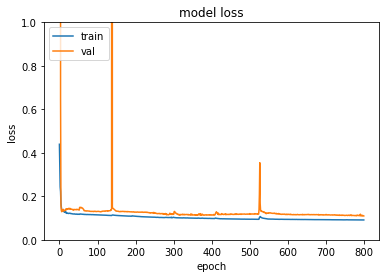

In [80]:
plot_history(history_model_multi_layers)

In [76]:
history_model_multi_layers.history.keys()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])

In [68]:
model = Sequential()

model.add(LSTM(units=256, return_sequences=True,input_shape=[16, number_of_features]))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(LSTM(units=128, return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.2))
#TimeDistributed layer
model.add(TimeDistributed(Dense(number_of_features)))

model.compile(loss="mae", optimizer=optimizer, metrics=['mae'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 16, 256)           2087936   
                                                                 
 batch_normalization_8 (Batc  (None, 16, 256)          1024      
 hNormalization)                                                 
                                                                 
 dropout_8 (Dropout)         (None, 16, 256)           0         
                                                                 
 lstm_11 (LSTM)              (None, 16, 128)           197120    
                                                                 
 batch_normalization_9 (Batc  (None, 16, 128)          512       
 hNormalization)                                                 
                                                                 
 dropout_9 (Dropout)         (None, 16, 128)          

In [81]:
model_multi_layers.save('lstm_800_e.h5')

In [95]:
test = val_all_np[-past:,:].reshape((1, past, number_of_features))

In [96]:
test


array([[[0.6532125 , 0.        , 0.3868528 , ..., 0.4059596 ,
         0.69828653, 0.6029426 ],
        [0.47712123, 0.        , 0.5113916 , ..., 0.70009804,
         0.91850716, 0.7255932 ],
        [0.39793998, 0.        , 0.22629434, ..., 0.32810736,
         0.8654007 , 0.79005706],
        ...,
        [0.        , 0.        , 0.        , ..., 0.47220516,
         0.9159484 , 0.7346902 ],
        [0.        , 0.        , 0.6991802 , ..., 0.33465004,
         0.8997447 , 0.69234216],
        [0.39793998, 0.        , 0.5113916 , ..., 0.687572  ,
         0.82971567, 0.6766397 ]]], dtype=float32)

In [109]:
Predict = model_multi_layers.predict(test)

In [110]:
Predict

array([[[ 3.6965591e-01,  1.7389012e-04,  3.6921644e-01, ...,
          3.3915070e-01,  2.5919470e-01,  6.4794302e-01],
        [ 3.6864752e-01,  6.8431080e-05,  3.7982821e-01, ...,
          3.0671164e-01,  2.2939387e-01,  6.4670593e-01],
        [ 3.9716944e-01,  3.7386999e-04,  3.9325941e-01, ...,
          3.0071294e-01,  2.2309616e-01,  6.1994559e-01],
        ...,
        [ 4.1059250e-01,  5.4166809e-05,  3.9696515e-01, ...,
          5.7578158e-01,  2.5335494e-01,  6.3128698e-01],
        [ 3.8927209e-01, -1.7339834e-04,  3.9541209e-01, ...,
          2.9224074e-01,  2.4553096e-01,  6.1766315e-01],
        [ 3.3109090e-01, -1.6189988e-04,  3.7474293e-01, ...,
          2.8168780e-01,  2.2700517e-01,  6.4108032e-01]]], dtype=float32)

In [100]:
# Predict.reshape((16, number_of_features))

array([[ 3.6965591e-01,  1.7389012e-04,  3.6921644e-01, ...,
         3.3915070e-01,  2.5919470e-01,  6.4794302e-01],
       [ 3.6864752e-01,  6.8431080e-05,  3.7982821e-01, ...,
         3.0671164e-01,  2.2939387e-01,  6.4670593e-01],
       [ 3.9716944e-01,  3.7386999e-04,  3.9325941e-01, ...,
         3.0071294e-01,  2.2309616e-01,  6.1994559e-01],
       ...,
       [ 4.1059250e-01,  5.4166809e-05,  3.9696515e-01, ...,
         5.7578158e-01,  2.5335494e-01,  6.3128698e-01],
       [ 3.8927209e-01, -1.7339834e-04,  3.9541209e-01, ...,
         2.9224074e-01,  2.4553096e-01,  6.1766315e-01],
       [ 3.3109090e-01, -1.6189988e-04,  3.7474293e-01, ...,
         2.8168780e-01,  2.2700517e-01,  6.4108032e-01]], dtype=float32)

In [111]:
Predict.shape

(1, 16, 1782)

In [112]:
Predict_inversed = minmax.inverse_transform(Predict.reshape((16, number_of_features)))

In [113]:
Predict_inversed.shape

(16, 1782)

In [115]:
# Inverse transform from the previous min max scaler
y_predict = pd.DataFrame(Predict_inversed,columns=X_pivoted.columns)

In [134]:
y_predict

store_nbr         1                                                    \
family           0         1         2         3         4         5    
0          1.544311  0.000174  1.354694  7.675069  0.187262  6.038983   
1          1.541989  0.000068  1.373708  7.704771  0.253827  6.059268   
2          1.607664  0.000374  1.397774  7.779405  0.216840  6.063324   
3          1.630347  0.001112  1.401060  7.748850  0.144777  5.976876   
4          1.128470  0.001172  1.136662  7.042006  0.088563  5.227509   
5          1.510883  0.000373  1.429281  7.708746  0.090520  6.078387   
6          1.640509  0.000251  1.412816  7.663773  0.100966  6.010575   
7          1.617059 -0.000062  1.408826  7.778501  0.105265  6.166919   
8          1.454713 -0.000052  1.374101  7.605061  0.085257  6.004877   
9          1.608418  0.000211  1.387649  7.738834  0.090577  6.062274   
10         1.634046  0.001034  1.391902  7.749573  0.082269  5.985116   
11         1.145507  0.001064  1.136423  7.031901  0.075631  5.243078   
12         1.511519  0.000181  1.418056  7.691638  0.091241  6.065864   
13         1.638571  0.000054  1.404413  7.646572  0.099340  5.999320   
14         1.589479 -0.000173  1.401631  7.754391  0.098794  6.145217   
15         1.455512 -0.000162  1.364596  7.589417  0.088662  5.989234   

store_nbr                                          ...         9            \
family           6         7         8         9   ...        23        24   
0          2.800738  6.613937  6.656946  4.957291  ...  1.279410  5.889663   
1          2.935014  6.644652  6.659185  4.955846  ...  1.298907  5.938157   
2          3.088867  6.633666  6.719116  5.111925  ...  1.441533  5.749404   
3          2.707307  6.459964  6.675728  4.921675  ...  1.757240  6.066064   
4          1.766250  5.750853  6.008966  4.212395  ...  1.804818  6.192298   
5          2.615857  6.621103  6.682580  5.004357  ...  1.317408  5.968786   
6          2.727686  6.624913  6.645810  4.943985  ...  1.317631  5.904322   
7          2.858568  6.755140  6.805826  5.007392  ...  1.245019  5.809328   
8          2.927638  6.576681  6.576608  4.853169  ...  1.292236  6.102261   
9          3.120891  6.641581  6.700318  5.098921  ...  1.369653  5.712239   
10         2.725450  6.455650  6.684869  4.931094  ...  1.746996  6.040757   
11         1.723283  5.697551  6.002352  4.218275  ...  1.732129  6.144797   
12         2.611160  6.576155  6.665757  4.991392  ...  1.271601  5.927308   
13         2.732496  6.574751  6.622676  4.932505  ...  1.274324  5.884755   
14         2.854315  6.701745  6.773626  4.985250  ...  1.233662  5.813873   
15         2.928596  6.539692  6.555883  4.829197  ...  1.283941  6.104760   

store_nbr                                                              \
family           25        26        27        28        29        30   
0          6.053737  1.770713  2.292630  6.050762  4.519764  7.214887   
1          5.998296  1.764273  2.233401  5.990381  4.515714  7.161172   
2          5.958526  1.777012  2.273731  6.111696  4.538804  7.151239   
3          6.473705  2.149848  2.700736  6.377760  4.914499  7.541142   
4          6.627496  2.321419  2.887187  6.534098  4.966452  7.777387   
5          6.214417  1.804887  2.396450  6.096796  4.576283  7.335397   
6          6.143366  1.838949  2.322069  6.006927  4.591448  7.653942   
7          6.011681  1.845341  2.246353  5.874268  4.522798  7.161857   
8          5.977831  1.746603  2.256940  5.960946  4.544698  7.147408   
9          5.895419  1.755864  2.211735  6.076587  4.490592  7.083200   
10         6.418585  2.125207  2.657028  6.344469  4.893250  7.514663   
11         6.532306  2.274240  2.816232  6.491646  4.957728  7.733036   
12         6.110182  1.753562  2.322988  6.039637  4.559003  7.280850   
13         6.040225  1.779293  2.251918  5.952786  4.580960  7.606714   
14         5.953893  1.807901  2.218297  5.851734  4.532488  7.137210   
15         5.920385  1.728786  2.223454

In [200]:
X_test_filtered = X_test[["store_nbr", "family", "date"]]
X_test_filtered

,store_nbr,family,date
3008016,1,0,2017-08-16
3008017,1,1,2017-08-16
3008018,1,2,2017-08-16
3008019,1,3,2017-08-16
3008020,1,4,2017-08-16
...,...,...,...
3036523,9,28,2017-08-31
3036524,9,29,2017-08-31
3036525,9,30,2017-08-31
3036526,9,31,2017-08-31


In [201]:
X_test_filtered

,store_nbr,family,date
3008016,1,0,2017-08-16
3008017,1,1,2017-08-16
3008018,1,2,2017-08-16
3008019,1,3,2017-08-16
3008020,1,4,2017-08-16
...,...,...,...
3036523,9,28,2017-08-31
3036524,9,29,2017-08-31
3036525,9,30,2017-08-31
3036526,9,31,2017-08-31


In [180]:
for index, row in y_predict.iterrows():
    #print(row)
    (X_test_pivoted.iloc[index]) = (y_predict.iloc[index])
    

In [187]:
X_test_filtered.pivot(index=['date'], columns=['store_nbr', 'family'], values=None)


sales                                      ...                      \
store_nbr      1                                      ...   9                   
family        0   1   2   3   4   5   6   7   8   9   ...  23  24  25  26  27   
date                                                  ...                       
2017-08-16   NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN   
2017-08-17   NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN   
2017-08-18   NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN   
2017-08-19   NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN   
2017-08-20   NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN   
2017-08-21   NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN   
2017-08-22   NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN   
2017-08-23   NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN   
2017-08-24   NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN   
2017-08-25   NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN   
2017-08-26   NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN   
2017-08-27   NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN   
2017-08-28   NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN   
2017-08-29   NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN   
2017-08-30   NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN   
2017-08-31   NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN   

                                
store_nbr                       
family      28  29  30  31  32  
date                            
2017-08-16 NaN NaN NaN NaN NaN  
2017-08-17 NaN NaN NaN NaN NaN  
2017-08-18 NaN NaN NaN NaN NaN  
2017-08-19 NaN NaN NaN NaN NaN  
2017-08-20 NaN NaN NaN NaN NaN  
2017-08-21 NaN NaN NaN NaN NaN  
2017-08-22 NaN NaN NaN NaN NaN  
2017-08-23 NaN NaN NaN NaN NaN  
2017-08-24 NaN NaN NaN NaN NaN  
2017-08-25 NaN NaN NaN NaN NaN  
2017-08-26 NaN NaN NaN NaN NaN  
2017-08-27 NaN NaN NaN NaN NaN  
2017-08-28 NaN NaN NaN NaN NaN  
2017-08-29 NaN NaN NaN NaN NaN  
2017-08-30 NaN NaN NaN NaN NaN  
2017-08-31 NaN NaN NaN NaN NaN  

[16 rows x 1782 columns]

In [191]:
X_test_pivoted.unstack().reset_index(name='sales')

,store_nbr,family,date,sales
0,1,0,2017-08-16,1.544311
1,1,0,2017-08-17,1.541989
2,1,0,2017-08-18,1.607664
3,1,0,2017-08-19,1.630347
4,1,0,2017-08-20,1.128470
...,...,...,...,...
28507,9,32,2017-08-27,3.263561
28508,9,32,2017-08-28,2.713312
28509,9,32,2017-08-29,2.668125
28510,9,32,2017-08-30,2.618533


In [204]:
result = pd.merge(X_test_filtered, X_test_pivoted.unstack().reset_index(name='sales'), how='outer', on=['store_nbr', 'family', 'date'])

In [205]:
result

,store_nbr,family,date,sales
0,1,0,2017-08-16,1.544311
1,1,1,2017-08-16,0.000174
2,1,2,2017-08-16,1.354694
3,1,3,2017-08-16,7.675069
4,1,4,2017-08-16,0.187262
...,...,...,...,...
28507,9,28,2017-08-31,5.921436
28508,9,29,2017-08-31,4.552744
28509,9,30,2017-08-31,7.119736
28510,9,31,2017-08-31,1.314351


In [206]:
result.reset_index().merge(X_test_filtered, how="left").set_index('index')

,store_nbr,family,date,sales
index,,,,
0,1,0,2017-08-16,1.544311
1,1,1,2017-08-16,0.000174
2,1,2,2017-08-16,1.354694
3,1,3,2017-08-16,7.675069
4,1,4,2017-08-16,0.187262
...,...,...,...,...
28507,9,28,2017-08-31,5.921436
28508,9,29,2017-08-31,4.552744
28509,9,30,2017-08-31,7.119736


In [211]:
X_test_filtered['id'] = X_test_filtered.index
submission = X_test_filtered.merge(result, how='left')[['id', 'sales']]
submission

/var/folders/zj/cjnnn8695qx8mqcc36hww0y80000gp/T/ipykernel_28079/3451258969.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_filtered['id'] = X_test_filtered.index


,id,sales
0,3008016,1.544311
1,3008017,0.000174
2,3008018,1.354694
3,3008019,7.675069
4,3008020,0.187262
...,...,...
28507,3036523,5.921436
28508,3036524,4.552744
28509,3036525,7.119736
28510,3036526,1.314351


In [212]:
submission.to_csv('submission.csv', index=False)